In [7]:
import gym
import sys
import numpy as np
import matplotlib
from collections import defaultdict
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
matplotlib.style.use("ggplot")

In [8]:
env = gym.make("Blackjack-v0")
state = env.reset()
print(state) # state: (player_score, Dealer_score, isAce)
action = env.action_space.sample()
print(action) # action: 0(停牌) or 1(要牌)

(19, 9, False)
0


In [9]:
def plot_value_function(V, title):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title=None):
        fig = plt.figure(figsize=(20, 10), facecolor='white')

        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        if title: ax.set_title(title)
        ax.view_init(ax.elev, -120)
        ax.set_facecolor("white")
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "(No Usable Ace)")
    plot_surface(X, Y, Z_ace, "(Usable Ace)")

In [10]:
def simple_policy(state):
    "简单策略：状态到动作的映射"
    player_score, _, _ = state
    return 0 if player_score >= 18 else 1

In [20]:
def mc_trajectory_collect(episode_trajectory, values_sum, values_count, discount=1.0, is_first= True):
    trajectory_len = len(episode_trajectory)
    gains = np.zeros(trajectory_len+1, dtype=np.float32)
    "一遍计算当前经验轨迹所有时刻的收益值: gain[i] = reward + discount * gain[i+1]"
    for i, data_i in enumerate(reversed(episode_trajectory)):
        i = trajectory_len - i - 1 # i = 0时，实际上i对应的下标为len-i-1
        gains[i] = data_i[2] + discount * gains[i+1]
    "收集"
    if(is_first):
        "首次访问"
        state_set = set()
        for i, data_i in enumerate(episode_trajectory):
            state = data_i[0]
            if(state in state_set):
                continue
            state_set.add(state)
            values_sum[state] += gains[i]
            values_count[state] += 1.0
    else:
        "每次访问"
        for i, data_i in enumerate(episode_trajectory):
            state = data_i[0]
            values_sum[state] += gains[i]
            values_count[state] += 1.0

In [21]:
def mc_firstvisit_preiction(environment, policy, max_episodes= 10000, episode_endtime= 10, discount= 1.0):
    """ 蒙特卡洛-首次访问预测算法
        input: environment, policy, max_episodes, episode_endtime, discount
        return: state_values
    """
    "1.初始化"
    env = environment
    state_values = defaultdict(float) # 状态函数
    values_sum = defaultdict(float) # 状态函数在所有幕的首次总和
    values_count = defaultdict(float) # 状态函数在所有幕的首次出现次数之和
    "2.蒙特卡洛预测"
    "2.1 对每一幕有"
    for episode in range(max_episodes):
        episode_trajectory = []
        state = env.reset()
        "2.2 访问每一幕的一条支链直到达到终点（或达到endtime）"
        for i in range(episode_endtime):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode_trajectory.append((state, action, reward))
            if(done):
                break
            state = next_state
        "2.3 进行蒙特卡洛经验轨迹数据的收集"
        mc_trajectory_collect(episode_trajectory, values_sum, values_count, discount=1.0, is_first= True)

    for state in values_count:
        state_values[state] = values_sum[state] / values_count[state]
    return state_values

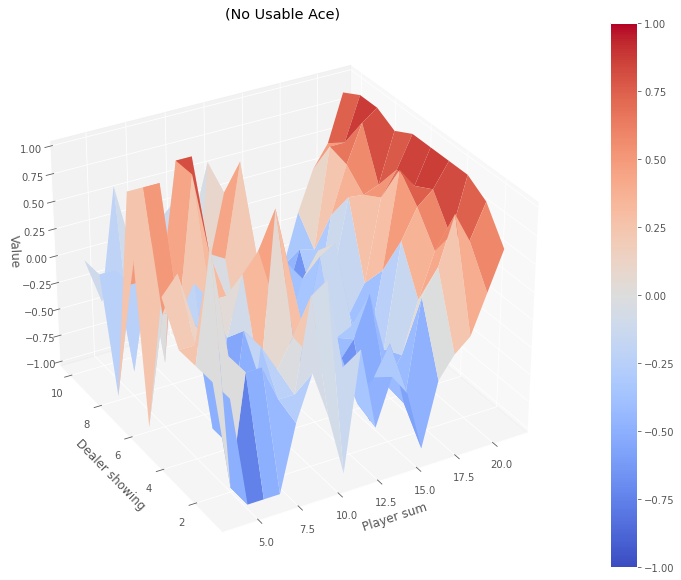

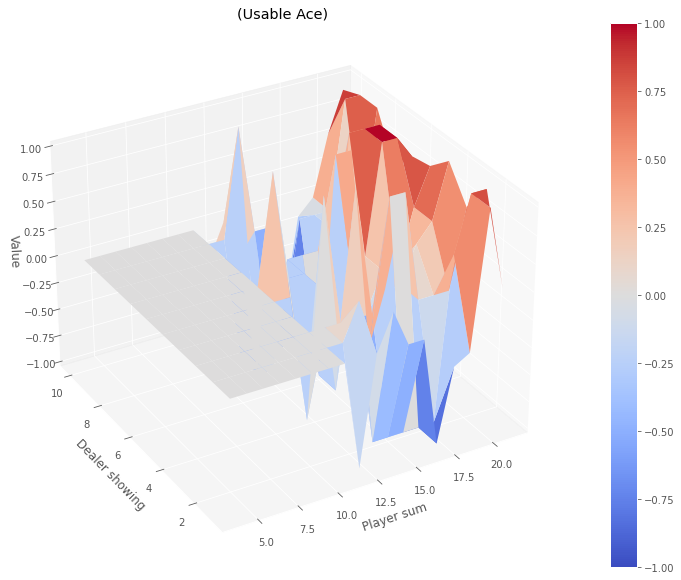

(4, 1, False) 0.0
(4, 1, True) 0.0
(4, 2, False) 0.0
(4, 2, True) 0.0
(4, 3, False) 0.0
(4, 3, True) 0.0
(4, 4, False) 0.0
(4, 4, True) 0.0
(4, 5, False) 0.3333333333333333
(4, 5, True) 0.0
(4, 6, False) -1.0
(4, 6, True) 0.0
(4, 7, False) 1.0
(4, 7, True) 0.0
(4, 8, False) -1.0
(4, 8, True) 0.0
(4, 9, False) 0.0
(4, 9, True) 0.0
(4, 10, False) 0.0
(4, 10, True) 0.0
(5, 1, False) -1.0
(5, 1, True) 0.0
(5, 2, False) -1.0
(5, 2, True) 0.0
(5, 3, False) 1.0
(5, 3, True) 0.0
(5, 4, False) 0.0
(5, 4, True) 0.0
(5, 5, False) 0.5
(5, 5, True) 0.0
(5, 6, False) 0.0
(5, 6, True) 0.0
(5, 7, False) 1.0
(5, 7, True) 0.0
(5, 8, False) 0.0
(5, 8, True) 0.0
(5, 9, False) 0.0
(5, 9, True) 0.0
(5, 10, False) -0.42857142857142855
(5, 10, True) 0.0
(6, 1, False) -1.0
(6, 1, True) 0.0
(6, 2, False) 0.0
(6, 2, True) 0.0
(6, 3, False) 0.0
(6, 3, True) 0.0
(6, 4, False) 0.0
(6, 4, True) 0.0
(6, 5, False) 0.0
(6, 5, True) 0.0
(6, 6, False) 0.0
(6, 6, True) 0.0
(6, 7, False) 1.0
(6, 7, True) 0.0
(6, 8, False) 

In [22]:
env = gym.make("Blackjack-v0")
v1 = mc_firstvisit_preiction(env, simple_policy, 1000)
plot_value_function(v1, "MC first visit")
for key in sorted(v1):
    print(key, v1[key])

In [23]:
def mc_everyvisit_preiction(environment, policy, max_episodes= 10000, episode_endtime= 10, discount= 1.0):
    """ 蒙特卡洛-每次访问预测算法
        input: environment, policy, max_episodes, episode_endtime, discount
        return: state_values
    """
    "1.初始化"
    env = environment
    state_values = defaultdict(float) # 状态函数
    values_sum = defaultdict(float) # 状态函数在所有幕的首次总和
    values_count = defaultdict(float) # 状态函数在所有幕的首次出现次数之和
    "2.蒙特卡洛预测"
    "2.1 对每一幕有"
    for episode in range(max_episodes):
        episode_trajectory = []
        state = env.reset()
        "2.2 访问每一幕的一条支链直到达到终点（或达到endtime）"
        for i in range(episode_endtime):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode_trajectory.append((state, action, reward))
            if(done):
                break
            state = next_state
        "2.3 进行蒙特卡洛经验轨迹数据的收集"
        mc_trajectory_collect(episode_trajectory, values_sum, values_count, discount=1.0, is_first= False)

    for state in values_count:
        state_values[state] = values_sum[state] / values_count[state]
    return state_values

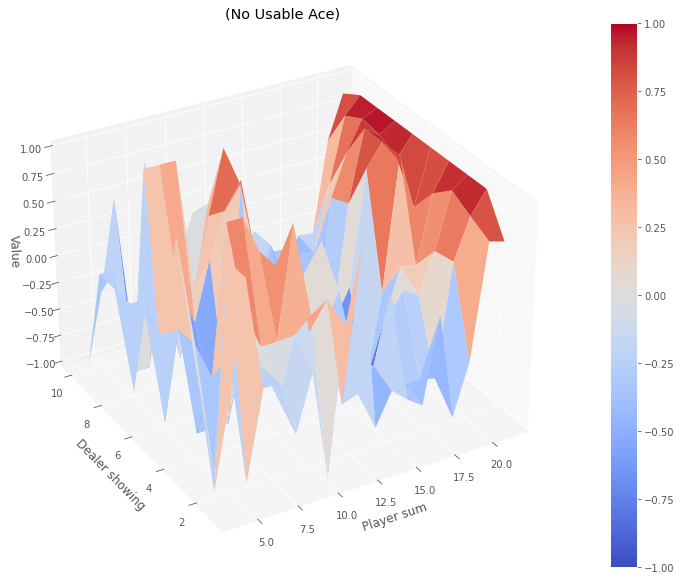

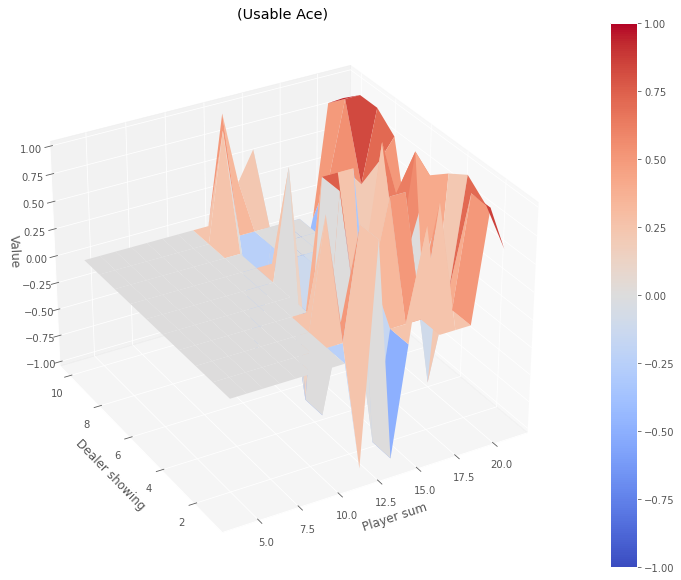

(4, 1, False) 0.0
(4, 1, True) 0.0
(4, 2, False) -1.0
(4, 2, True) 0.0
(4, 3, False) 0.0
(4, 3, True) 0.0
(4, 4, False) 1.0
(4, 4, True) 0.0
(4, 5, False) 0.0
(4, 5, True) 0.0
(4, 6, False) 0.0
(4, 6, True) 0.0
(4, 7, False) 0.0
(4, 7, True) 0.0
(4, 8, False) 0.0
(4, 8, True) 0.0
(4, 9, False) 0.0
(4, 9, True) 0.0
(4, 10, False) -1.0
(4, 10, True) 0.0
(5, 1, False) 1.0
(5, 1, True) 0.0
(5, 2, False) 1.0
(5, 2, True) 0.0
(5, 3, False) -1.0
(5, 3, True) 0.0
(5, 4, False) 0.0
(5, 4, True) 0.0
(5, 5, False) 0.0
(5, 5, True) 0.0
(5, 6, False) -1.0
(5, 6, True) 0.0
(5, 7, False) 0.0
(5, 7, True) 0.0
(5, 8, False) -1.0
(5, 8, True) 0.0
(5, 9, False) 0.0
(5, 9, True) 0.0
(5, 10, False) -0.3333333333333333
(5, 10, True) 0.0
(6, 1, False) 0.0
(6, 1, True) 0.0
(6, 2, False) -1.0
(6, 2, True) 0.0
(6, 3, False) 0.0
(6, 3, True) 0.0
(6, 4, False) -0.3333333333333333
(6, 4, True) 0.0
(6, 5, False) -1.0
(6, 5, True) 0.0
(6, 6, False) 0.0
(6, 6, True) 0.0
(6, 7, False) -1.0
(6, 7, True) 0.0
(6, 8, Fals

In [24]:
env = gym.make("Blackjack-v0")
v2 = mc_everyvisit_preiction(env, simple_policy, 1000)
plot_value_function(v2, "MC every visit")
for key in sorted(v2):
    print(key, v2[key])